# Определение именованных сущностей в рецептах

Рассмотрим задачу поиска именованных сущностей в тексте на примере рецептов еды, а также обучим нейросеть LSTM, которая будет автоматически решать эту задачу

* [1] https://open.blogs.nytimes.com/2015/04/09/extracting-structured-data-from-recipes-using-conditional-random-fields
* [2] https://open.blogs.nytimes.com/2016/04/27/structured-ingredients-data-tagging
* [3] https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py
* [4] https://pytorch.org/tutorials/beginner/saving_loading_models.html
* [5] https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
* [6] https://en.wikipedia.org/wiki/Named-entity_recognition

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
# Для выполнения этого задания не забудьте установить:
# !pip3 install spacy_udpipe
# !pip3 install ipymarkup
# !pip3 install livelossplot

QUICK_RUN = True

In [3]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd

In [5]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
df = pd.read_csv('datasets/nyt-ingredients-head.csv')

- input - строка с рецептом блюда
- name - основной продукт блюда
- quantity и range_end - количество основного продукта
- unit - ед.изм.
- comment - доп. сведения

In [6]:
df[0:5]

,index,input,name,qty,range_end,unit,comment
0,0,1 1/4 cups cooked and pureed fresh butternut s...,butternut squash,1.25,0.0,cup,"cooked and pureed fresh, or 1 10-ounce package..."
1,1,1 cup peeled and cooked fresh chestnuts (about...,chestnuts,1.00,0.0,cup,"peeled and cooked fresh (about 20), or 1 cup c..."
2,2,"1 medium-size onion, peeled and chopped",onion,1.00,0.0,NaN,"medium-size, peeled and chopped"
3,3,"2 stalks celery, chopped coarse",celery,2.00,0.0,stalk,chopped coarse
4,4,1 1/2 tablespoons vegetable oil,vegetable oil,1.50,0.0,tablespoon,NaN


## Аннотированные (BIO) рецепты

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [8]:
# на темном фоне выбранная в пакете dlnlputils палитра нечитаемая, подкрутим
from ipymarkup.palette import material, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

colors = BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

for c in colors:
    color_name = c.name[0].capitalize() + c.name[1:]
    c.background = material(color_name, '900')

In [9]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
datafile = 'datasets/BIO_recipe_dataset.txt'
lines    = open(datafile, encoding='utf-8').read().strip().split('\n')

#### словарь и тэги:

In [10]:
from dlnlputils.recipe_utils import form_vocabulary_and_tagset, prepare_data, show_markup, Converter, tag_statistics, plot_confusion_matrix, recipe_statistics, plot_recipe_statistics

- Перевели наш файл с рецептами в формат BIO, когда каждому слову соответствует тэг

In [11]:
vocabulary, labels = form_vocabulary_and_tagset(lines)

#### рецепты:


- Взяли из него первые 50 тысяч рецептов

In [12]:
recipes_w_tags = prepare_data(lines)

len(recipes_w_tags)

49847

In [13]:
test_recipe, test_tags = recipes_w_tags[0]

show_markup(test_recipe, test_tags)

#### перевод слов и тэгов в индексы - и обратно:

Формат BIO подразумевает, что каждая именованная сущность может состоять из нескольких слов: "b" — beginning, "inter" — это продолжение.

Построим два индексных словаря — для слов, которые содержатся в рецептах, и для их тэгов. Для этого мы определим объект `Converter`


In [14]:
converter = Converter(vocabulary,labels)

Исходный рецепт выглядит следующим образом — 
- в сконвертированном виде каждому слову будут соответствовать индексы в словаре токенов, 
- каждому тэгу будет соответствовать индекс в словаре тэгов.

Декодирование - ОК


In [15]:
test_recipe, test_tags = recipes_w_tags[0]

encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()

decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

show_markup(decoded_recipe, decoded_tags)

tensor([  57, 2245, 2133, 1520, 4060, 2650, 1846, 4624,   25, 3729,   42,  125,
        3771, 2668, 4624,   25, 2303])
tensor([3, 5, 0, 6, 6, 6, 2, 7, 9, 6, 6, 6, 6, 6, 2, 9, 6])



Тренировочная и тестовая выборки (80/20)

In [16]:
training_data = recipes_w_tags[     :40000]
test_data     = recipes_w_tags[40000:]

Алгоритмы NER можно использовать при решении таких задач, как:

1. Анализ мнений: определить не только тональность высказывания но и предмет, о котором сделано высказывание.
2. Семантическая аннотация: автоматически определить объекты, о которых идет речь в статье на Википедии, чтобы прикрепить к ним ссылки на статьи о них Википедии.
3. Вопросно ответные системы: программа получает на вход текст и вопросы о его содержании, например, "кто главный герой текста?", "в каком городе он живет?". Вопросно ответная система должна научиться отвечать на такие вопросы. Помните школьные тесты на уроках иностранного языка?

В нашем случае именованные сущности - это Продукт, его Количество, Мера Измерения и Комментарий (о продукте и о том, как его приготовить). Если мы научимся извлекать эти знания из рецепта, мы сможем построить рекомендательную систему, которая будет способна, например, предлагать вегетарианские рецепты или рецепты с вашими любимыми продуктами.

То есть,  BIO разметка выглядит следующим образом (данные поменялисть, на примере другого рецепта):

    1	        B-QTY
    medium-size	B-COMMENT
    onion	        B-NAME
    ,	        B-COMMENT
    peeled	        I-COMMENT
    and	        I-COMMENT
    chopped	        I-COMMENT

    2	        B-QTY
    stalks	        B-UNIT
    celery	        B-NAME
    ,	        OTHER
    chopped	        B-COMMENT
    coarse	        I-COMMENT

    1$1/2	        B-QTY
    tablespoons	B-UNIT
    vegetable	B-NAME
    oil	        I-NAME

## LSTM

1. Для входящих слов - найдём их индексы в словаре, 
2. Найдем соответствующие им векторы в эмбеддинг-матрице. 
3. Далее, каждый из этих векторов попадёт в нашу нейросеть LSTM следующим образом: 
   - сначала попадает первый вектор, 
   - нейросеть генерирует некий промежуточный результат и получает его же себе на вход одновременно с вектором следующего слова, 
   - производит ещё один промежуточный результат, получит его на вход с вектором уже следующего слова, 
   - и для каждого такого промежуточного состояния мы применяем модуль, связанный с предсказанием тэга. 
     - Например, для вектора "cup" это будет тэг "quantity", для "of" это будет "comment", для "tea" наш модуль предскажет "name".

В функции `predict_tags()` для деактивации autograd (без вычисления градиентов будет использоваться меньше памяти и скорость работы увеличится) мы делаем вызов `torch.no_grad()`.

**Косячная разметка**

Изучая .csv файл с оригинальной разметкой рецептов можно наткнуться в частности на такие примеры:  

      1QTY teaspoonUNIT baking powderNAME
      1QTY cupUNIT plain lowfatCOMMENT yogurtNAME

В первом примере baking powderNAME (мука для выпекания) выделена в отдельную сущность (ОК), тогда как plain lowfatCOMMENT yogurtNAME (обезжиренный йогурт без добавок) поделен на раздельные сущности.

Для принятия решения об объединении нескольких слов в именованную сущность можно использовать критерии: 

- Частоту n-граммы
- $pmi(l, w) = log \frac{p(w, l)} {p(w) p(l)}$
- Языковую модель (например, skip-gram)
​


In [17]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

In [18]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

In [19]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss() 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

Нейросеть обучается довольно быстро, потому что наш датасет сравнительно мал. 
- минут 10 на 5 эпох на хосте
- большая дисперсия ошибок, т.к. тут щитай размер батча 1 и это типа щитай покоординатный спуск, а не пакетный (?)

In [20]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

if not QUICK_RUN:
    # почему эпоха это 500 примеров? эпоха же это все примеры...
    for epoch in range(5): 
        for i, (recipe, tags) in enumerate(training_data):
            
            model.zero_grad()
            
            encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
            encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
            
            tag_scores     = model(encoded_recipe)

            loss = loss_function(tag_scores, encoded_tags)
            loss.backward()
            optimizer.step()
            
            if i % 500 == 0:
                liveplot.update({'negative log likelihood loss': loss.detach().numpy()})
                liveplot.draw()
                
            if i == len(training_data):  # типа по всем примерам
                break

Определим функцию `predict_tags`: 
- нейросеть (уже обученная) получает на вход слова, находятся их индексы в словаре, 
- они попадают в нейросеть, и мы предсказываем тэги для слов. 

In [21]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    
    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags


Рассмотрим 10 реальных примеров предсказания тэгов рецептов. 

Ошибок довольно много

In [22]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,7000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    show_markup(recipe, tags)

    print('предсказанные тэги:')
    show_markup(recipe, tags_pred)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


### Save & Load model

In [23]:
if QUICK_RUN:
    model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
    model.load_state_dict(torch.load('models/recipe.pt'))
else:
    torch.save(model.state_dict(), 'models/recipe.pt')

In [24]:
model.eval()

recipe, tags = test_data[4444]

tags_pred = predict_tags(model, converter, recipe)

print('ground truth:')
print(list(zip(recipe, tags)))
print()

print('prediction:')
print(list(zip(recipe, tags_pred)))   


print('ground truth:')
show_markup(recipe, tags)

print('prediction:')
show_markup(recipe, tags_pred)

print()

ground truth:
[('1', 'B-QTY'), ('tablespoon', 'B-UNIT'), ('cornstarch', 'B-NAME')]

prediction:
[('1', 'B-QTY'), ('tablespoon', 'B-UNIT'), ('cornstarch', 'B-NAME')]
ground truth:


prediction:


## Проверка возможностей нейросети на тестовых данных:

### Количество верно предсказанных тэгов:

In [25]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для B-QTY:
  корректно:	 8303
      всего:	 8420
% корректно:	 98.61045130641331

для B-COMMENT:
  корректно:	 6464
      всего:	 7823
% корректно:	 82.62814776939793

для B-RANGE_END:
  корректно:	 138
      всего:	 156
% корректно:	 88.46153846153845

для B-UNIT:
  корректно:	 6969
      всего:	 7074
% корректно:	 98.51569126378287

для B-NAME:
  корректно:	 9161
      всего:	 10278
% корректно:	 89.13212687293249

для I-NAME:
  корректно:	 4401
      всего:	 5528
% корректно:	 79.61287988422576

для I-COMMENT:
  корректно:	 13599
      всего:	 14984
% корректно:	 90.75680726107849

для OTHER:
  корректно:	 2160
      всего:	 4101
% корректно:	 52.67008046817849

----------
в итоге:
  корректно:	 51195
      всего:	 58364
% корректно:	 87.71674319786169


### Матрица Ошибок (Confusion Matrix)

In [26]:
y_pred = []
y_true = []

for recipe, tags in test_data:
    y_pred += predict_tags(model,converter, recipe)
    y_true += tags

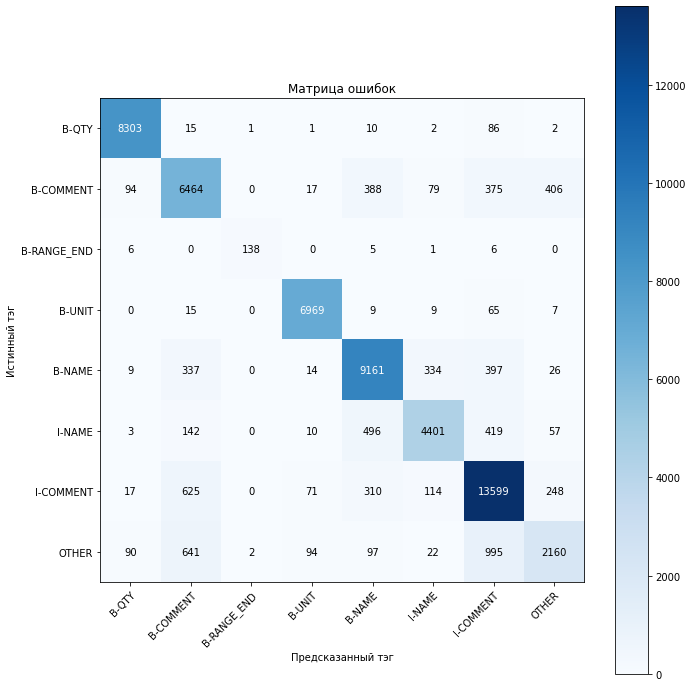

In [27]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

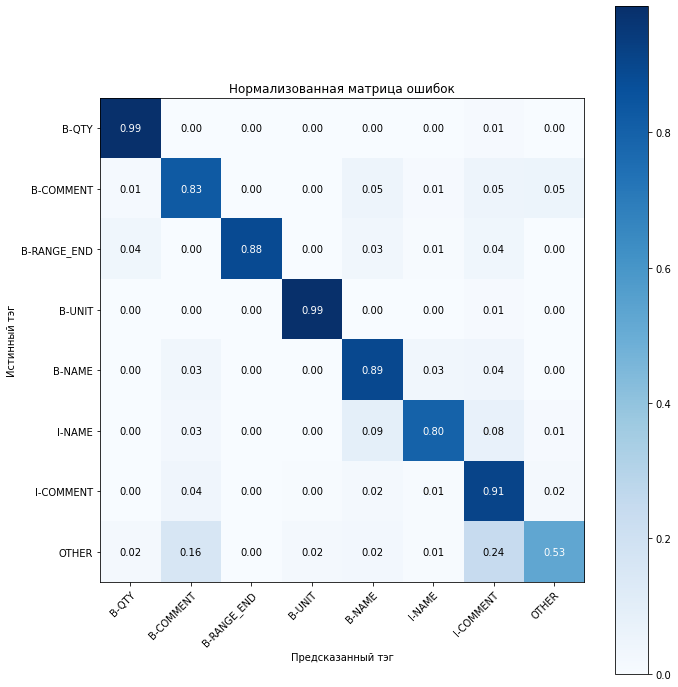

In [28]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()

### Количество верно размеченных рецептов:

In [29]:
correct_recipes, total_recipes = recipe_statistics(model, converter, test_data, 4)

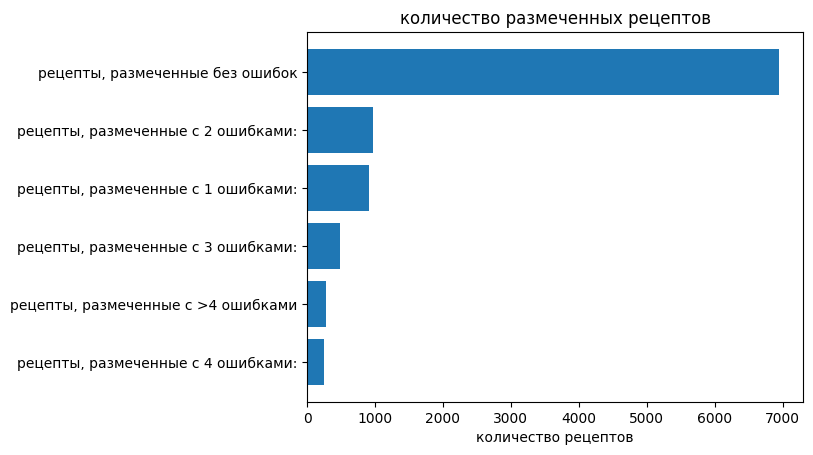

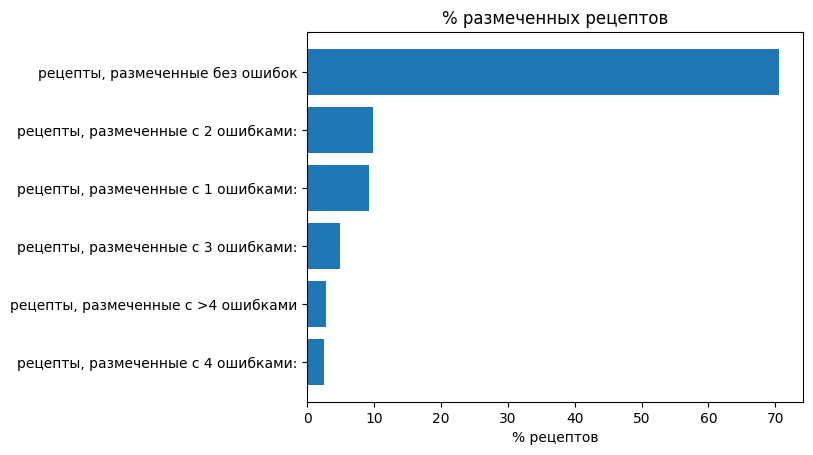

In [30]:
plot_recipe_statistics(correct_recipes)
plot_recipe_statistics(correct_recipes, total_recipes)